# Finding effective transformation for adversarial data augmentation for cardiac MR image segmentation

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

import torch
import torchvision
import sys
import torch.nn as nn
%matplotlib inline
sns.set()
use_gpu=True

print (torch.__version__)
print (torchvision.__version__)

1.11.0
0.12.0


In [20]:
# sys.path.append('path/to/advchain')
sys.path.append('/vol/biomedic3/cc215/Project/advchain/')


In [21]:
from advchain.augmentor import ComposeAdversarialTransformSolver,AdvBias,AdvMorph,AdvNoise,AdvAffine
from advchain.common.utils import random_chain,load_image_label
from advchain.common.loss import cross_entropy_2D
from advchain.common.vis import plot_warped_grid, plot_noise,plot_bias_field,plot_image,plot_general
from  advchain.models.unet import get_unet_model
from advchain.common.layers import Fixable2DDropout, Fixable3DDropout

In [22]:
torch.cuda.empty_cache()

1.1 Load data

In [23]:
image_path ='./data/cardiac/img.nrrd'
label_path ='./data/cardiac/seg.nrrd'
slice_id = 2
crop_size=(192,192)
cropped_image,cropped_label =load_image_label (image_path,label_path,slice_id=slice_id,crop_size=crop_size)



1.2 Preprocessing data

(-0.5, 191.5, 191.5, -0.5)

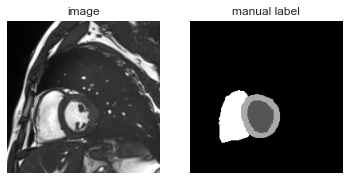

In [24]:
font_size=12
plt.subplot(121)
plt.title('image',size=font_size)
plt.imshow(cropped_image,cmap='gray')
plt.axis('off')

plt.subplot(122)
plt.imshow(cropped_label,cmap='gray')
plt.title('manual label',size=font_size)
plt.axis('off')


2 Load a segmentation model

In [25]:
model = get_unet_model(num_classes=4,model_path='./saved_checkpoints/cardiac_seg_unet_16.pth',model_arch='UNet_16')

if use_gpu: model = model.cuda()
model.eval()

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(32

(-0.5, 191.5, 191.5, -0.5)

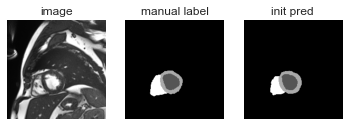

In [26]:
cropped_image,cropped_label =load_image_label(image_path,label_path,slice_id=5,crop_size=crop_size)
font_size=12
image_tensor = torch.from_numpy(cropped_image[np.newaxis,np.newaxis,:,:]).float()
label_tensor = torch.from_numpy(cropped_image[np.newaxis,:,:]).long()
if use_gpu: 
    image_tensor = image_tensor.cuda()
    label_tensor = label_tensor.cuda()
image_tensor.requires_grad=False
init_output = model(image_tensor)
pred_map = init_output.max(1)[1].cpu().data.numpy()

plt.subplot(131)
plt.title('image',size=font_size)
plt.imshow(cropped_image,cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.imshow(cropped_label,cmap='gray')
plt.title('manual label',size=font_size)
plt.axis('off')
plt.subplot(133)
plt.imshow(pred_map[0],cmap='gray')
plt.title('init pred',size=font_size)
plt.axis('off')

3.1 Set up basic transformations

In [27]:
bs=1
im_ch=1
debug = False ## set debug to false to disable intermediate outputs
augmentor_bias= AdvBias(
                 config_dict={'epsilon':0.3,
                 'control_point_spacing':[crop_size[0]//2,crop_size[1]//2],
                 'downscale':2,
                 'data_size':(bs,im_ch,crop_size[0],crop_size[1]),
                 'interpolation_order':3,
                 'init_mode':'random',
                 'space':'log'},debug=debug)

                 

augmentor_noise= AdvNoise( config_dict={'epsilon':1,
                'xi':1e-6,
                 'data_size':(bs,im_ch,crop_size[0],crop_size[1])},
                 debug=debug)
    
augmentor_affine= AdvAffine( config_dict={
                 'rot':30.0/180,
                 'scale_x':0.,
                 'scale_y':0,
                 'shift_x':0,
                 'shift_y':0,
                 'data_size':(bs,im_ch,crop_size[0],crop_size[1]),
                 'forward_interp':'bilinear',
                 'backward_interp':'bilinear'},
                 debug=debug)

augmentor_morph= AdvMorph(
                config_dict=
                {'epsilon':1.5,
                 'data_size':(bs,im_ch,crop_size[0],crop_size[1]),
                 'vector_size':[crop_size[0]//16,crop_size[1]//16],
                 'interpolator_mode':'bilinear'
                 }, 
                 debug=debug)



  


3.2. Set up a solver for adversarial data augmentation

In [28]:
## keep model fixed, set up a solver
model.eval()
transformation_chain = [augmentor_noise,augmentor_bias,augmentor_morph,augmentor_affine] ## specify an order: noise->bias->morph->affine
# transformation_chain = [augmentor_affine,augmentor_morph,augmentor_bias,augmentor_noise] ## specify an order: noise->bias->morph->affine

solver = ComposeAdversarialTransformSolver(
        chain_of_transforms=transformation_chain,
        divergence_types = ['mse','contour'], ### you can also change it to 'kl'.
        divergence_weights=[1.0,0.5],
        use_gpu= True,
        debug=True,
        if_norm_image=False
       )

4.1. Start learning

In [29]:
# random initialization
slice_id=0
solver.init_random_transformation()
rand_transformed_image = solver.forward(image_tensor.detach().clone())
rand_predict = model.forward(rand_transformed_image)
warp_back_rand_predict= solver.predict_backward(rand_predict)

rand_bias = augmentor_bias.bias_field
rand_noise = augmentor_noise.param
rand_dxy,rand_morph = augmentor_morph.get_deformation_displacement_field(-augmentor_morph.param)
rand_deformed_image =augmentor_morph.transform((image_tensor+rand_noise)*rand_bias,rand_dxy).cpu().data.numpy()[slice_id,0]

loss = solver.adversarial_training(
        data=image_tensor,model=model,
        n_iter=1,
        lazy_load=[True]*len(transformation_chain), ## if set to true, it will use the previous sampled random bias field as initialization.
        optimize_flags=[True]*len(transformation_chain),
        step_sizes=1,power_iteration=[False]*len(transformation_chain))

adv_bias= augmentor_bias.bias_field
adv_noise = augmentor_noise.param
adv_dxy,adv_morph = augmentor_morph.get_deformation_displacement_field(-augmentor_morph.param)
adv_transformed_image = solver.forward(image_tensor.detach().clone())
adv_predict = model.forward(adv_transformed_image)
warp_back_adv_predict= solver.predict_backward(adv_predict)

[inner loop], step 0: dist 0.011802153661847115
update noise parameters
update bias parameters
update morph parameters
update affine parameters
[outer loop] loss 0.03869616985321045


4.2. Visualization

<AxesSubplot:title={'center':'Diff'}>

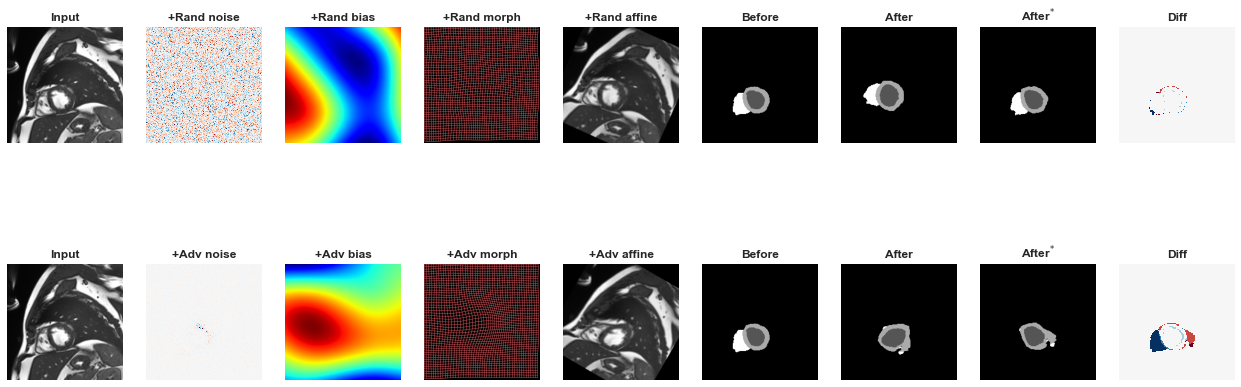

In [30]:
slice_id = 0
sns.set(font_scale=10)
rand_transformed_image_numpy=rand_transformed_image.cpu().data.numpy()[slice_id,0]
adv_transformed_image_numpy=adv_transformed_image.cpu().data.numpy()[slice_id,0]

rand_predict_numpy=warp_back_rand_predict.max(1)[1].cpu().data.numpy()[slice_id]
adv_predict_numpy=warp_back_adv_predict.max(1)[1].cpu().data.numpy()[slice_id]

rand_before_warped_predict_numpy=rand_predict.max(1)[1].cpu().data.numpy()[slice_id]
adv_before_warped_predict_numpy=adv_predict.max(1)[1].cpu().data.numpy()[slice_id]

rand_bias_numpy=rand_bias.cpu().data.numpy()[slice_id,0]
adv_bias_numpy=adv_bias.cpu().data.numpy()[slice_id,0]

rand_noise_numpy=rand_noise.cpu().data.numpy()[slice_id,0]
adv_noise_numpy=adv_noise.cpu().data.numpy()[slice_id,0]

rand_morph_grid = rand_morph.permute(0,3,1,2)[slice_id].data.cpu().numpy()
adv_morph_grid = adv_morph.permute(0,3,1,2)[slice_id].data.cpu().numpy()
rand_deformed_image =augmentor_morph.transform((image_tensor+rand_noise)*rand_bias,rand_dxy).cpu().data.numpy()[slice_id,0]
adv_deformed_image =augmentor_morph.transform(image_tensor,adv_dxy).cpu().data.numpy()[slice_id,0]

gird_interval = 4
vis_deforme_image=False ## turn it on to see deformed image
fig,axes = plt.subplots(2,9,figsize=(22,8))
plot_image(image_tensor.data.cpu().numpy()[slice_id,0],ax = axes[0,0],title='Input',font_size=font_size)
plot_noise(rand_noise_numpy,ax = axes[0,1],title='+Rand noise',font_size=font_size)
plot_bias_field(rand_bias_numpy,ax= axes[0,2],title='+Rand bias')
plot_warped_grid(rand_morph_grid, ax=axes[0,3],bg_img=rand_deformed_image*vis_deforme_image, interval=gird_interval, title="+Rand morph", fontsize=font_size, linewidth=0.5,show=True)
plot_image(rand_transformed_image_numpy, ax=axes[0,4],title="+Rand affine", font_size=font_size)
plot_image(pred_map[slice_id],ax = axes[0,5],title='Before',font_size=font_size)
plot_image(rand_before_warped_predict_numpy,ax = axes[0,6],title='After',font_size=font_size)
plot_image(rand_predict_numpy,ax = axes[0,7],title='After${}^{*}$',font_size=font_size)
plot_noise(rand_predict_numpy-pred_map[slice_id],ax = axes[0,8],title='Diff',font_size=font_size)

plot_image(image_tensor.data.cpu().numpy()[slice_id,0],title='Input',ax = axes[1,0],font_size=font_size)
plot_noise(adv_noise_numpy,ax = axes[1,1],title='+Adv noise',font_size=font_size)
plot_bias_field(adv_bias_numpy,ax= axes[1,2],title='+Adv bias')
plot_warped_grid(adv_morph_grid, ax=axes[1,3],bg_img=adv_deformed_image*vis_deforme_image, interval=gird_interval, title="+Adv morph", fontsize=font_size, linewidth=0.5,show=True)
plot_image(adv_transformed_image_numpy, ax=axes[1,4],title="+Adv affine", font_size=font_size)
plot_image(pred_map[slice_id],title='Before',ax = axes[1,5],font_size=font_size)
plot_image(adv_before_warped_predict_numpy,ax = axes[1,6],title='After',font_size=font_size)
plot_image(adv_predict_numpy,title='After${}^{*}$',ax = axes[1,7],font_size=font_size)
plot_noise(adv_predict_numpy-pred_map[slice_id],ax = axes[1,8],title='Diff',font_size=font_size)
# plt.savefig('./test_chain_image.png')


5. Example: plug-in adversarial training code to enhance cardiac segmentation network training

In [31]:
## now you can simply learn effective adversarial transformation on-the-fly to enhance training. a sample code will be like the following
## pseudo code for model optimization at one iteration: 
from advchain.common.utils import random_chain
## sample a chain
transformation_family = [augmentor_noise,augmentor_bias,augmentor_morph,augmentor_affine]

one_chain = random_chain(transformation_family.copy(),max_length=2)[0]

print ('sample a chain:')
[print ('-> '+tr.get_name()) for tr in one_chain]

solver = ComposeAdversarialTransformSolver(
        chain_of_transforms=one_chain,
        divergence_types = ['mse','contour'], ### you can also change it to 'kl'
        divergence_weights=[1.0,0.5],
        use_gpu= True,
        debug=True, ## turn off debugging information when training your model
        if_norm_image=False,
       )

## compute consistency loss
reg_loss = solver.adversarial_training(
        data = image_tensor,model=model,
        n_iter = 1, ## set up  the number of iterations for updating the transformation model.
        lazy_load = [False]*len(one_chain), 
        optimize_flags = [True]*len(one_chain),  ## you can also turn off adversarial training for one particular transformation
        step_sizes = 1) ## set up step size, you can also change it to a list of step sizes, so that different transformation have different step size

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
optimizer.zero_grad(set_to_none=True)
model.train()
model.zero_grad()
init_output = model(image_tensor)

## compute supervised loss
supervised_loss = cross_entropy_2D (init_output,label_tensor)
lamda=1
total_loss = supervised_loss+lamda*reg_loss
total_loss.backward()
optimizer.step() 
## !important, please reset the transformation parameters.
solver.reset_transformation()

sample a chain:
-> morph
-> noise
[inner loop], step 0: dist 0.02213931828737259
update morph parameters
update noise parameters
[outer loop] loss 0.031426142901182175


In [32]:
torch.cuda.empty_cache()



3D  version (beta)

In [33]:
## 3D   version

image_path ='./data/cardiac/img.nrrd'
label_path ='./data/cardiac/seg.nrrd'
slice_id = 2
crop_size=(192,192)
cropped_image_3d,cropped_label_3d =load_image_label (image_path,label_path,slice_id=-1,crop_size=crop_size)

cropped_image_3d =cropped_image_3d.reshape(1,1,cropped_image_3d.shape[0],cropped_image_3d.shape[1],cropped_image_3d.shape[2])
cropped_label_3d =cropped_label_3d.reshape(1,cropped_label_3d.shape[0],cropped_label_3d.shape[1],cropped_label_3d.shape[2])



image_tensor_3d = torch.from_numpy(cropped_image_3d).float()
label_tensor_3d = torch.from_numpy(cropped_label_3d).long()
image_tensor_3d = image_tensor_3d.permute(0,1,3,4,2)
label_tensor_3d = image_tensor_3d.permute(0,1,3,4,2)
print (image_tensor_3d.size())

if use_gpu: 
    image_tensor_3d = image_tensor_3d.cuda()
    label_tensor_3d = label_tensor_3d.cuda()
# image_tensor_3d = torch.randn((1,1,192,192,192))

torch.Size([1, 1, 192, 192, 10])


In [34]:
bs=1
im_ch=1
debug = False ## set debug to false to disable intermediate outputs
augmentor_bias= AdvBias(
                spatial_dims=3,
                 config_dict={'epsilon':0.3,
                 'control_point_spacing':[image_tensor_3d.size(2)//2,image_tensor_3d.size(3)//2,image_tensor_3d.size(4)//2],
                 'downscale':4,
                 'data_size':image_tensor_3d.size(),
                 'interpolation_order':3,
                 'init_mode':'random',
                 'space':'log'},debug=debug)

                 

augmentor_noise= AdvNoise( 
                spatial_dims=3,
                config_dict={'epsilon':1,
                'xi':1e-6,
                 'data_size':image_tensor_3d.size(),},
                 debug=debug)
    
augmentor_affine= AdvAffine( spatial_dims=3, config_dict={
                'rot_x':10.0/180,
                'rot_y':10.0/180,
                 'rot_z':10.0/180,
                 'scale_x':0.1,
                 'scale_y':0.1,
                 'scale_z':0.1,
                 'shift_x':0.1,
                 'shift_y':0.1,
                 'shift_z':0.1,
                 'data_size':image_tensor_3d.size(),
                 'forward_interp':'bilinear',
                 'backward_interp':'bilinear'},
                 debug=debug)

augmentor_morph= AdvMorph(
                spatial_dims=3,
                config_dict=
                {'epsilon':15,
                 'data_size':image_tensor_3d.size(),
                 'vector_size':[image_tensor_3d.size(2)//16,image_tensor_3d.size(3)//16,image_tensor_3d.size(4)//2],
                 'interpolator_mode':'bilinear'
                 }, 
                 debug=debug)


## create a pseudo 3D segmentation model for test
model_3d =torch.nn.Sequential(
    torch.nn.Conv3d(1, 4, 3, padding=1),
    torch.nn.BatchNorm3d(4),
    Fixable3DDropout(0.1), ## please use Fixable3DDropout layers intead of torch.nn.Dropout3d in your network
    torch.nn.Softmax(dim=1),
)
nn.init.kaiming_normal_(model_3d[0].weight, mode='fan_out', nonlinearity='relu')
if use_gpu:
    model_3d = model_3d.cuda()
## keep model fixed, set up a solver
model_3d.eval()
transformation_chain = [augmentor_noise,augmentor_bias,augmentor_morph, augmentor_affine] ## specify an order: noise->bias->morph->affine
solver = ComposeAdversarialTransformSolver(
        chain_of_transforms=transformation_chain,
        divergence_types = ['mse','contour'], ### you can also change it to 'kl'.
        divergence_weights=[1.0,0.5],
        use_gpu= True,
        debug=True,
        if_norm_image=False
       )

In [35]:
# random initialization
solver.init_random_transformation()
rand_transformed_image = solver.forward(image_tensor_3d.detach().clone())
orig_predict = model_3d.forward(image_tensor_3d.detach().clone())

rand_predict = model_3d.forward(rand_transformed_image)
warp_back_rand_predict= solver.predict_backward(rand_predict)

loss = solver.adversarial_training(
        data=image_tensor_3d,model=model_3d,
        n_iter=1,
        lazy_load=[True]*len(transformation_chain), ## if set to true, it will use the previous sampled random bias field as initialization.
        optimize_flags=[True]*len(transformation_chain),
        step_sizes=1,power_iteration=[False]*len(transformation_chain))


adv_transformed_image = solver.forward(image_tensor_3d.detach().clone())
adv_predict = model_3d.forward(adv_transformed_image)
warp_back_adv_predict= solver.predict_backward(adv_predict)


[inner loop], step 0: dist 0.0011630879016593099
update noise parameters
update bias parameters
update morph parameters
update affine parameters
[outer loop] loss 0.06206267699599266


<AxesSubplot:title={'center':'Diff'}>

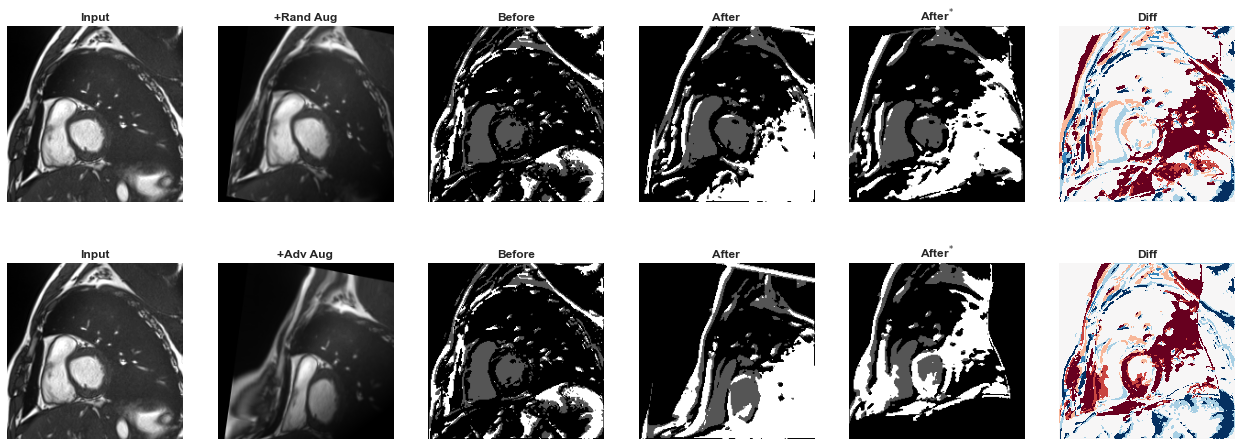

In [36]:
slice_id = 0
sns.set(font_scale=10)
rand_transformed_image_numpy=rand_transformed_image.cpu().data.numpy()[0,0,:,:,slice_id]
adv_transformed_image_numpy=adv_transformed_image.cpu().data.numpy()[0,0,:,:,slice_id]

rand_predict_numpy=warp_back_rand_predict.max(1)[1].cpu().data.numpy()[0,:,:,slice_id]
adv_predict_numpy=warp_back_adv_predict.max(1)[1].cpu().data.numpy()[0,:,:,slice_id]
orig_predict_numpy  =orig_predict.max(1)[1].cpu().data.numpy()[0,:,:,slice_id]
rand_before_warped_predict_numpy=rand_predict.max(1)[1].cpu().data.numpy()[0,:,:,slice_id]
adv_before_warped_predict_numpy=adv_predict.max(1)[1].cpu().data.numpy()[0,:,:,slice_id]


gird_interval = 4
vis_deforme_image=False ## turn it on to see deformed image
fig,axes = plt.subplots(2,6,figsize=(22,8))
plot_image(image_tensor_3d.data.cpu().numpy()[0,0,:,:,slice_id],ax = axes[0,0],title='Input',font_size=font_size)
plot_image(rand_transformed_image_numpy, ax=axes[0,1],title="+Rand Aug", font_size=font_size)
plot_image(orig_predict_numpy,ax = axes[0,2],title='Before',font_size=font_size)
plot_image(rand_before_warped_predict_numpy,ax = axes[0,3],title='After',font_size=font_size)
plot_image(rand_predict_numpy,ax = axes[0,4],title='After${}^{*}$',font_size=font_size)
plot_noise(rand_predict_numpy-orig_predict_numpy,ax = axes[0,5],title='Diff',font_size=font_size)

plot_image(image_tensor_3d.data.cpu().numpy()[0,0,:,:,slice_id],title='Input',ax = axes[1,0],font_size=font_size)
plot_image(adv_transformed_image_numpy, ax=axes[1,1],title="+Adv Aug", font_size=font_size)
plot_image(orig_predict_numpy,title='Before',ax = axes[1,2],font_size=font_size)
plot_image(adv_before_warped_predict_numpy,ax = axes[1,3],title='After',font_size=font_size)
plot_image(adv_predict_numpy,title='After${}^{*}$',ax = axes[1,4],font_size=font_size)
plot_noise(adv_predict_numpy-orig_predict_numpy,ax = axes[1,5],title='Diff',font_size=font_size)